 **Get Data**

In [37]:
import pandas as pd
import numpy as np

In [122]:
#annual_df = pd.read_csv("/content/annual_ocean.csv", index_col="Year")

annual_df = pd.read_csv("/content/annual_ocean.csv")
# Veriyi ters çevirme
annual_df = annual_df[::-1]

# Ters çevrilen sütunu "Year" sütunu olarak yeniden adlandırma (isteğe bağlı)
annual_df = annual_df.rename(columns={"Year": "Year"})

# Veriyi "Year" sütununu indeks olarak kullanarak okuma
annual_df = annual_df.set_index("Year")

In [123]:
annual_df

,Source,Mean
Year,,
1880,GISTEMP,-0.2000
1880,GCAG,-0.1148
1881,GISTEMP,-0.1200
1881,GCAG,-0.0628
1882,GISTEMP,-0.1000
...,...,...
2014,GCAG,0.7408
2015,GISTEMP,0.8700
2015,GCAG,0.8998


In [130]:
annual_df

,Mean
Year,
1880,-0.2000
1880,-0.1148
1881,-0.1200
1881,-0.0628
1882,-0.1000
...,...
2014,0.7408
2015,0.8700
2015,0.8998


In [131]:
missing_mean = annual_df['Mean'].isnull().sum()
print(f"Mean sütununda {missing_mean} eksik değer bulunuyor.")

Mean sütununda 0 eksik değer bulunuyor.


In [132]:
annual_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274 entries, 1880 to 2016
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mean    274 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB


In [133]:
annual_df_years = annual_df
annual_df_years.head(10)

,Mean
Year,
1880,-0.2000
1880,-0.1148
1881,-0.1200
1881,-0.0628
1882,-0.1000
1882,-0.0648
1883,-0.2100
1883,-0.1424
1884,-0.2800


In [134]:
annual_df_years.head(10)

,Mean
Year,
1880,-0.2000
1880,-0.1148
1881,-0.1200
1881,-0.0628
1882,-0.1000
1882,-0.0648
1883,-0.2100
1883,-0.1424
1884,-0.2800


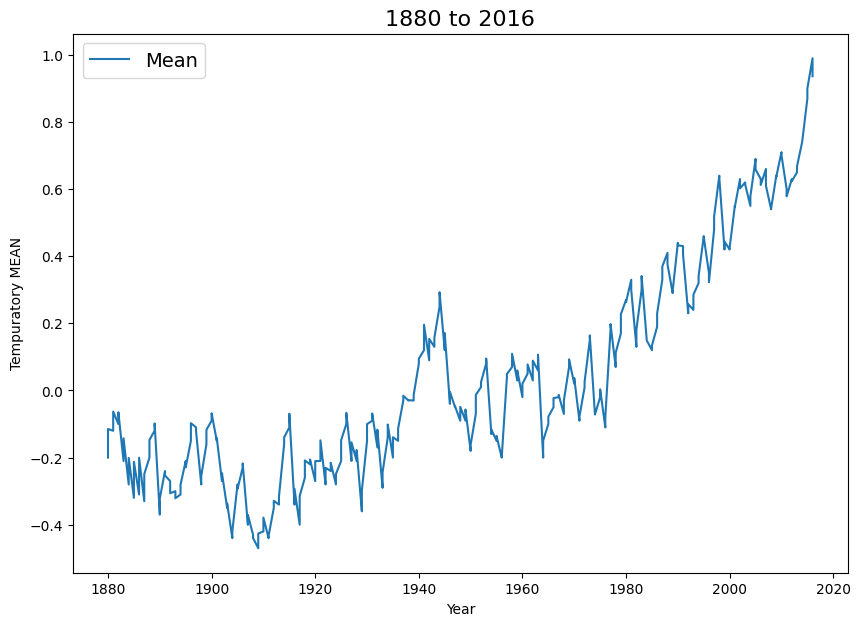

In [135]:
import matplotlib.pyplot as plt
annual_df_years.plot(figsize=(10, 7))
plt.ylabel("Tempuratory MEAN")
plt.title("1880 to 2016", fontsize=16)
plt.legend(fontsize=14);

In [136]:
# Get bitcoin date array
timesteps = annual_df_years.index.to_numpy()
means = annual_df_years["Mean"].to_numpy()

timesteps[:10], means[:10]

(array([1880, 1880, 1881, 1881, 1882, 1882, 1883, 1883, 1884, 1884]),
 array([-0.2   , -0.1148, -0.12  , -0.0628, -0.1   , -0.0648, -0.21  ,
        -0.1424, -0.28  , -0.2009]))

In [137]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(means)) # 80% train, 20% test

# Create train data splits (first 80%)
X_train, y_train = timesteps[:split_size], means[:split_size]

# Create test data splits (last 20%)
X_test, y_test = timesteps[split_size:], means[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(219, 55, 219, 55)

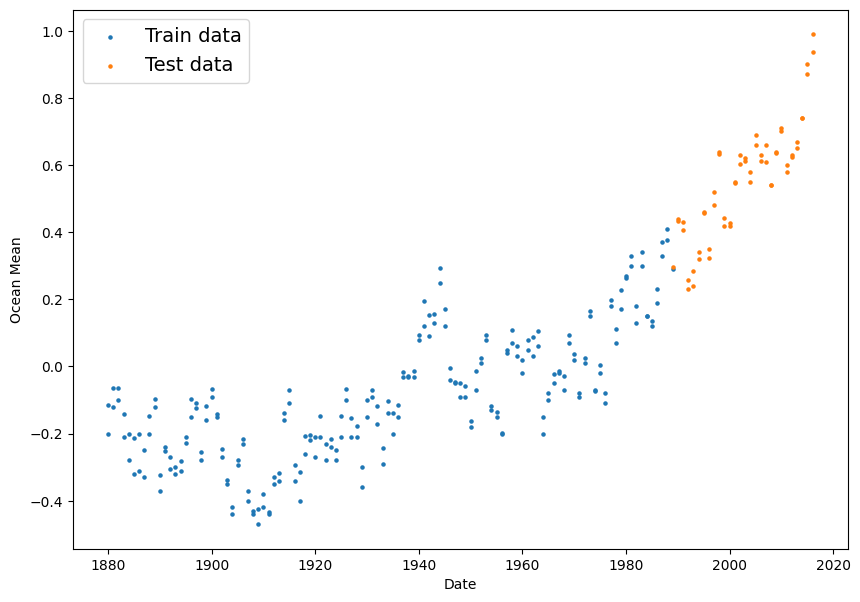

In [138]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Ocean Mean")
plt.legend(fontsize=14)
plt.show();

**Train and Test Split**

In [139]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Ocean MEAN")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [28]:
import tensorflow as tf

In [30]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [31]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

 **Windowing our Data**

In [140]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [33]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [141]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [35]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [142]:
full_windows, full_labels = make_windows(means, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(267, 267)

In [45]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [0.9363 0.99   0.8998 0.87   0.7408 0.74   0.6679] -> Label: [0.65]
Window: [0.99   0.8998 0.87   0.7408 0.74   0.6679 0.65  ] -> Label: [0.624]
Window: [0.8998 0.87   0.7408 0.74   0.6679 0.65   0.624 ] -> Label: [0.63]


In [46]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [-0.2009 -0.28   -0.1424 -0.21   -0.0648 -0.1    -0.0628] -> Label: [-0.12]
Window: [-0.28   -0.1424 -0.21   -0.0648 -0.1    -0.0628 -0.12  ] -> Label: [-0.1148]
Window: [-0.1424 -0.21   -0.0648 -0.1    -0.0628 -0.12   -0.1148] -> Label: [-0.2]


In [47]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [143]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(213, 54, 213, 54)

In [49]:
train_windows[:5], train_labels[:5]

(array([[0.9363, 0.99  , 0.8998, 0.87  , 0.7408, 0.74  , 0.6679],
        [0.99  , 0.8998, 0.87  , 0.7408, 0.74  , 0.6679, 0.65  ],
        [0.8998, 0.87  , 0.7408, 0.74  , 0.6679, 0.65  , 0.624 ],
        [0.87  , 0.7408, 0.74  , 0.6679, 0.65  , 0.624 , 0.63  ],
        [0.7408, 0.74  , 0.6679, 0.65  , 0.624 , 0.63  , 0.5788]]),
 array([[0.65  ],
        [0.624 ],
        [0.63  ],
        [0.5788],
        [0.6   ]]))

In [50]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

**MODEL 1 : DENSE MODEL(WINDOW=7 , HORIZON=1)**

In [144]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
history_model_1= model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=25,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels)) # create ModelCheckpoint callback to save best model

Epoch 1/25
2/2 [==============================] - 2s 247ms/step - loss: 0.2279 - mae: 0.2279 - val_loss: 0.4161 - val_mae: 0.4161
Epoch 2/25
2/2 [==============================] - 0s 63ms/step - loss: 0.1895 - mae: 0.1895 - val_loss: 0.3359 - val_mae: 0.3359
Epoch 3/25
2/2 [==============================] - 0s 49ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.2624 - val_mae: 0.2624
Epoch 4/25
2/2 [==============================] - 0s 59ms/step - loss: 0.1202 - mae: 0.1202 - val_loss: 0.1961 - val_mae: 0.1961
Epoch 5/25
2/2 [==============================] - 0s 44ms/step - loss: 0.0971 - mae: 0.0971 - val_loss: 0.1403 - val_mae: 0.1403
Epoch 6/25
2/2 [==============================] - 0s 54ms/step - loss: 0.0871 - mae: 0.0871 - val_loss: 0.0946 - val_mae: 0.0946
Epoch 7/25
2/2 [==============================] - 0s 46ms/step - loss: 0.0856 - mae: 0.0856 - val_loss: 0.0758 - val_mae: 0.0758
Epoch 8/25
2/2 [==============================] - 0s 54ms/step - loss: 0.0879 - mae: 0.0879 - va

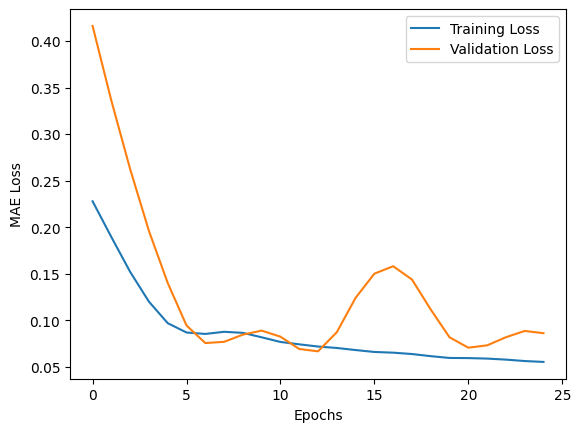

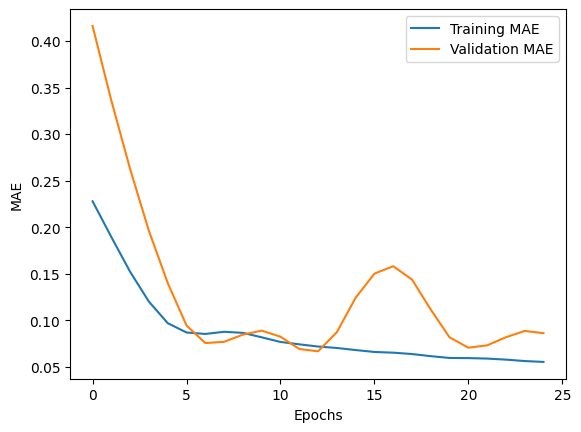

In [145]:
import matplotlib.pyplot as plt

# Eğitimdeki kayıp değerlerini çizin
plt.plot(history_model_1.history['loss'], label='Training Loss')
plt.plot(history_model_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

# Eğitimdeki metrik değerlerini çizin
plt.plot(history_model_1.history['mae'], label='Training MAE')
plt.plot(history_model_1.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [146]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 7ms/step - loss: 0.0864 - mae: 0.0864


[0.08636884391307831, 0.08636884391307831]

In [147]:
# Load in saved best performing model_1 and evaluate on test data
model_1.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 7ms/step - loss: 0.0864 - mae: 0.0864


[0.08636884391307831, 0.08636884391307831]

In [56]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [148]:
#Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

2/2 [==============================] - 0s 3ms/step


(54,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.28912708, 0.37205613, 0.38147298, 0.4090353 , 0.3878362 ,
        0.2493293 , 0.2750691 , 0.24207342, 0.2676253 , 0.31545392],
       dtype=float32)>)

In [149]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 0.086368844,
 'mse': 0.010934659,
 'rmse': 0.10456892,
 'mape': 15.543959,
 'mase': 1.6974632}

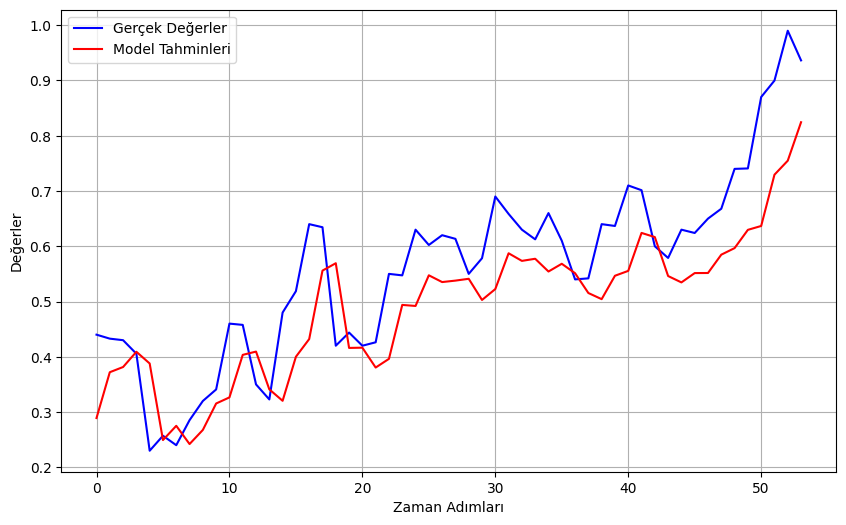

In [150]:
import matplotlib.pyplot as plt

# Test verileri ve model tahminleri
y_true = tf.squeeze(test_labels)
y_pred = model_1_preds

# Timesteps dizisini test verilerinin uzunluğuna uygun olarak oluştur
timesteps = range(len(y_true))

# Gerçek değerleri çiz (mavi çizgi)
plt.figure(figsize=(10, 6))
plt.plot(timesteps, y_true, label="Gerçek Değerler", color="blue")

# Tahminleri çiz (kırmızı çizgi)
plt.plot(timesteps, y_pred, label="Model Tahminleri", color="red")

# Etiketler ve grafik düzenlemeleri
plt.xlabel("Zaman Adımları")
plt.ylabel("Değerler")
plt.legend()
plt.grid(True)

# Grafik göstermek için plt.show() kullanın
plt.show()

**MODEL 2 : DENSE MODEL(WINDOW= 30 , HORIZON=1)**

In [151]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [152]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(means, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(244, 244)

In [153]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(195, 49, 195, 49)

In [156]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

history_model_2=model_2.fit(train_windows,
            train_labels,
            epochs=50,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels))

Epoch 1/50
2/2 [==============================] - 2s 193ms/step - loss: 0.1488 - mae: 0.1488 - val_loss: 0.5474 - val_mae: 0.5474
Epoch 2/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1385 - mae: 0.1385 - val_loss: 0.3979 - val_mae: 0.3979
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1101 - mae: 0.1101 - val_loss: 0.3083 - val_mae: 0.3083
Epoch 4/50
2/2 [==============================] - 0s 37ms/step - loss: 0.1061 - mae: 0.1061 - val_loss: 0.2167 - val_mae: 0.2167
Epoch 5/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0919 - mae: 0.0919 - val_loss: 0.1175 - val_mae: 0.1175
Epoch 6/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0877 - mae: 0.0877 - val_loss: 0.0724 - val_mae: 0.0724
Epoch 7/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0830 - mae: 0.0830 - val_loss: 0.0858 - val_mae: 0.0858
Epoch 8/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0770 - mae: 0.0770 - va

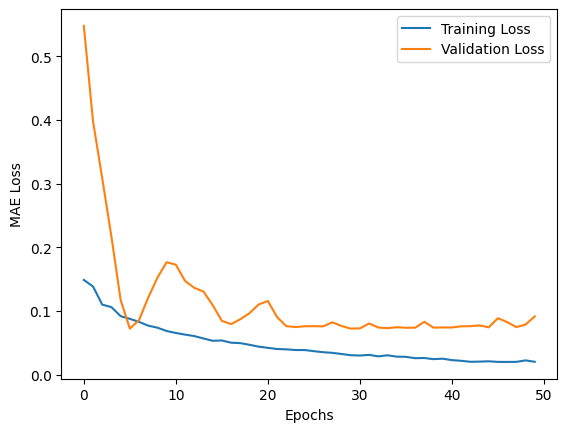

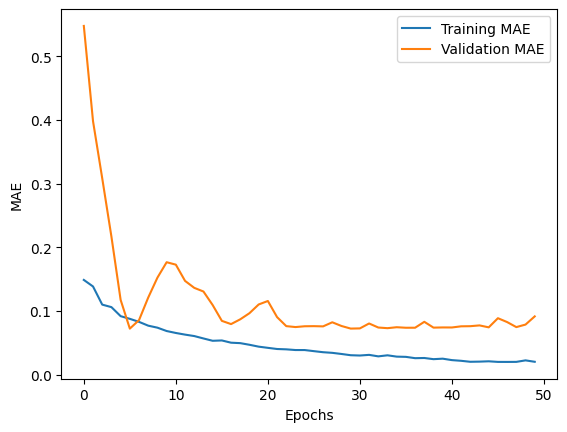

In [157]:
import matplotlib.pyplot as plt

# Eğitimdeki kayıp değerlerini çizin
plt.plot(history_model_2.history['loss'], label='Training Loss')
plt.plot(history_model_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

# Eğitimdeki metrik değerlerini çizin
plt.plot(history_model_2.history['mae'], label='Training MAE')
plt.plot(history_model_2.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [158]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 7ms/step - loss: 0.0916 - mae: 0.0916


[0.09158091992139816, 0.09158091992139816]

In [159]:
# Load in best performing model
model_2.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 7ms/step - loss: 0.0916 - mae: 0.0916


[0.09158091992139816, 0.09158091992139816]

In [160]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

2/2 [==============================] - 0s 4ms/step


In [161]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 0.09158092,
 'mse': 0.014160228,
 'rmse': 0.118996754,
 'mape': 14.917546,
 'mase': 1.7872354}

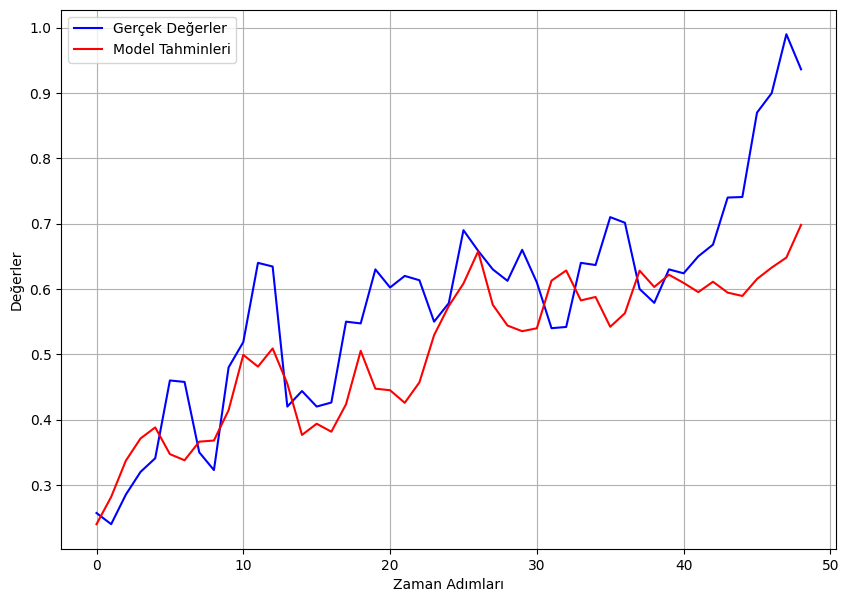

In [162]:
# Test verileri ve model tahminleri
y_true = tf.squeeze(test_labels)
y_pred = model_2_preds

# Timesteps dizisini test verilerinin uzunluğuna uygun olarak oluştur
timesteps = range(len(y_true))

# Gerçek değerleri çiz (mavi çizgi)
plt.figure(figsize=(10, 7))
plt.plot(timesteps, y_true, label="Gerçek Değerler", color="blue")

# Tahminleri çiz (kırmızı çizgi)
plt.plot(timesteps, y_pred, label="Model Tahminleri", color="red")

# Etiketler ve grafik düzenlemeleri
plt.xlabel("Zaman Adımları")
plt.ylabel("Değerler")
plt.legend()
plt.grid(True)

# Grafik göstermek için plt.show() kullanın
plt.show()

**Model 3: Dense (window = 30, horizon = 7)**

In [163]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(means, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(238, 238)

In [164]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(190, 48, 190, 48)

In [165]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

history_model_3=model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=50,
            verbose=1,
            validation_data=(test_windows, test_labels))

Epoch 1/50
2/2 [==============================] - 3s 158ms/step - loss: 0.1819 - mae: 0.1819 - val_loss: 0.5361 - val_mae: 0.5361
Epoch 2/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1552 - mae: 0.1552 - val_loss: 0.5030 - val_mae: 0.5030
Epoch 3/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1421 - mae: 0.1421 - val_loss: 0.4658 - val_mae: 0.4658
Epoch 4/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1343 - mae: 0.1343 - val_loss: 0.4198 - val_mae: 0.4198
Epoch 5/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1274 - mae: 0.1274 - val_loss: 0.3686 - val_mae: 0.3686
Epoch 6/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1207 - mae: 0.1207 - val_loss: 0.3131 - val_mae: 0.3131
Epoch 7/50
2/2 [==============================] - 0s 34ms/step - loss: 0.1161 - mae: 0.1161 - val_loss: 0.2693 - val_mae: 0.2693
Epoch 8/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1129 - mae: 0.1129 - va

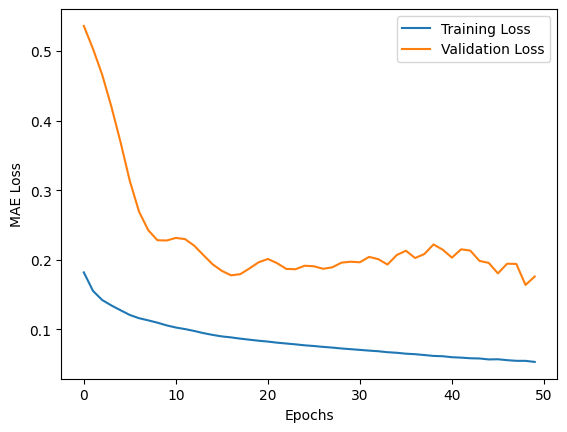

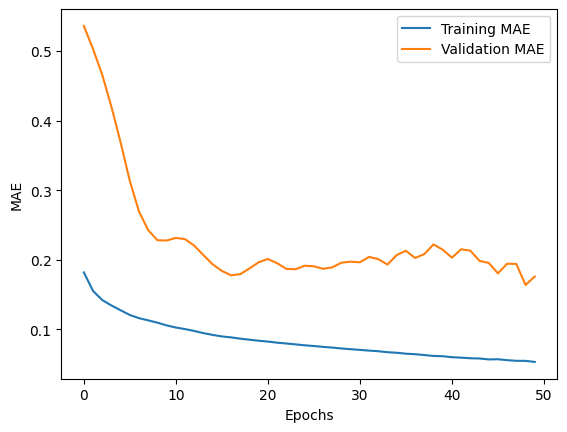

In [166]:
# Eğitimdeki kayıp değerlerini çizin
plt.plot(history_model_3.history['loss'], label='Training Loss')
plt.plot(history_model_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

# Eğitimdeki metrik değerlerini çizin
plt.plot(history_model_3.history['mae'], label='Training MAE')
plt.plot(history_model_3.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [167]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 7ms/step - loss: 0.1759 - mae: 0.1759


[0.1759200543165207, 0.1759200543165207]

In [168]:
# Load in best version of model_3 and evaluate
model_3.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 7ms/step - loss: 0.1759 - mae: 0.1759


[0.1759200543165207, 0.1759200543165207]

In [169]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

2/2 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[0.35778165, 0.391403  , 0.5226255 , 0.46791855, 0.48602656,
        0.38835597, 0.36035734],
       [0.42363563, 0.38549143, 0.5044281 , 0.45222315, 0.5035819 ,
        0.39491835, 0.4026466 ],
       [0.482186  , 0.3379868 , 0.4330166 , 0.48356876, 0.45848447,
        0.39584845, 0.43914703],
       [0.46472755, 0.3207521 , 0.41842332, 0.5022543 , 0.49202842,
        0.43727705, 0.46993798],
       [0.46839684, 0.32059684, 0.41057327, 0.4989879 , 0.49532095,
        0.4448715 , 0.49630296]], dtype=float32)>

In [170]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 0.17592005,
 'mse': 0.04489021,
 'rmse': 0.20018952,
 'mape': 34.763706,
 'mase': 3.4512224}

In [84]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [171]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 0.17592005,
 'mse': 0.04489021,
 'rmse': 0.20018952,
 'mape': 34.763706,
 'mase': 3.4512224}

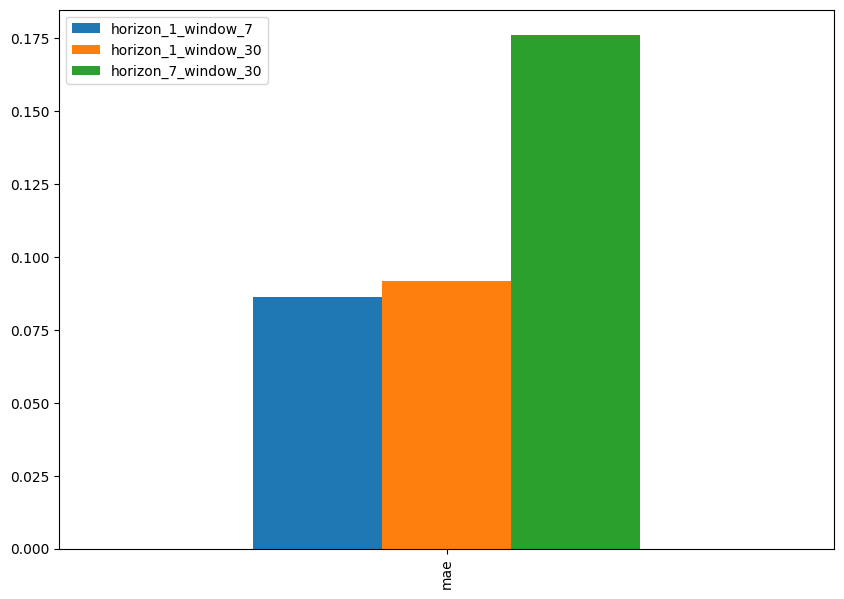

In [172]:
pd.DataFrame({
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

**Model 4: Conv1D**

In [173]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [174]:
# Create windowed dataset
full_windows, full_labels = make_windows(means, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(267, 267)

In [175]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(213, 54, 213, 54)

In [176]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [177]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[-0.2   ]
 [-0.1148]
 [-0.12  ]
 [-0.0628]
 [-0.1   ]
 [-0.0648]
 [-0.21  ]]


In [178]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu"),
  layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation="relu"),
  layers.Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
history_model_4=model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=40,
            verbose=1,
            validation_data=(test_windows, test_labels))

Epoch 1/40
2/2 [==============================] - 2s 220ms/step - loss: 0.1793 - mae: 0.1793 - val_loss: 0.4993 - val_mae: 0.4993
Epoch 2/40
2/2 [==============================] - 0s 32ms/step - loss: 0.1689 - mae: 0.1689 - val_loss: 0.4589 - val_mae: 0.4589
Epoch 3/40
2/2 [==============================] - 0s 31ms/step - loss: 0.1589 - mae: 0.1589 - val_loss: 0.4147 - val_mae: 0.4147
Epoch 4/40
2/2 [==============================] - 0s 48ms/step - loss: 0.1480 - mae: 0.1480 - val_loss: 0.3621 - val_mae: 0.3621
Epoch 5/40
2/2 [==============================] - 0s 52ms/step - loss: 0.1351 - mae: 0.1351 - val_loss: 0.3005 - val_mae: 0.3005
Epoch 6/40
2/2 [==============================] - 0s 32ms/step - loss: 0.1220 - mae: 0.1220 - val_loss: 0.2314 - val_mae: 0.2314
Epoch 7/40
2/2 [==============================] - 0s 36ms/step - loss: 0.1092 - mae: 0.1092 - val_loss: 0.1648 - val_mae: 0.1648
Epoch 8/40
2/2 [==============================] - 0s 33ms/step - loss: 0.0976 - mae: 0.0976 - va

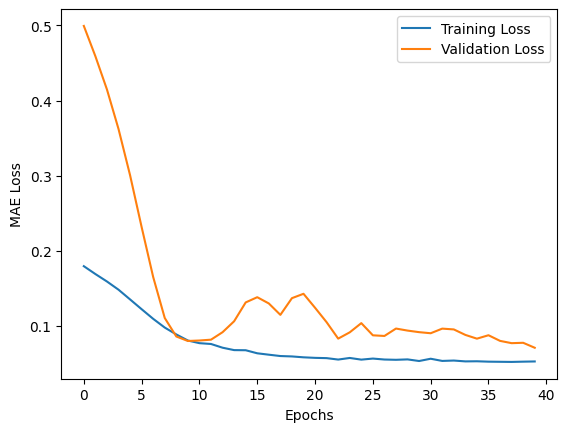

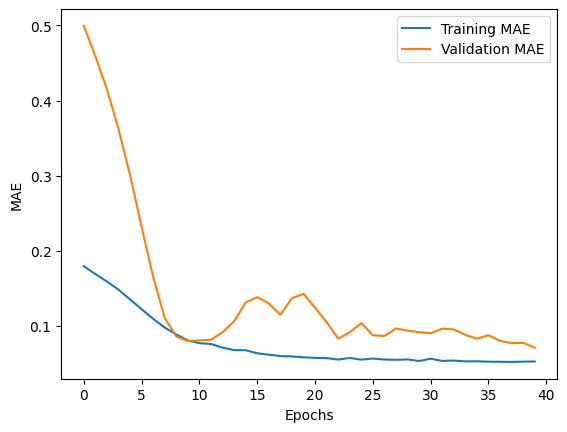

In [179]:
import matplotlib.pyplot as plt

# Eğitimdeki kayıp değerlerini çizin
plt.plot(history_model_4.history['loss'], label='Training Loss')
plt.plot(history_model_4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

# Eğitimdeki metrik değerlerini çizin
plt.plot(history_model_4.history['mae'], label='Training MAE')
plt.plot(history_model_4.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [180]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 128)            2816      
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 64)             24640     
                                                                 
 conv1d_8 (Conv1D)           (None, 1, 32)             6176      
                                                                 
 dense_38 (Dense)            (None, 1, 1)              33        
                                                                 
Total params: 33665 (131.50 KB)
Trainable params: 33665 (131.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [181]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 7ms/step - loss: 0.0707 - mae: 0.0707


[0.07068721950054169, 0.07068721950054169]

In [182]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

2/2 [==============================] - 0s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.29975846, 0.4344282 , 0.43544438, 0.41488013, 0.38844025,
       0.26001954, 0.2603961 , 0.25778246, 0.29110163, 0.32401127],
      dtype=float32)>

In [183]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results


{'mae': 0.07068722,
 'mse': 0.008233899,
 'rmse': 0.09074084,
 'mape': 12.708786,
 'mase': 1.389262}

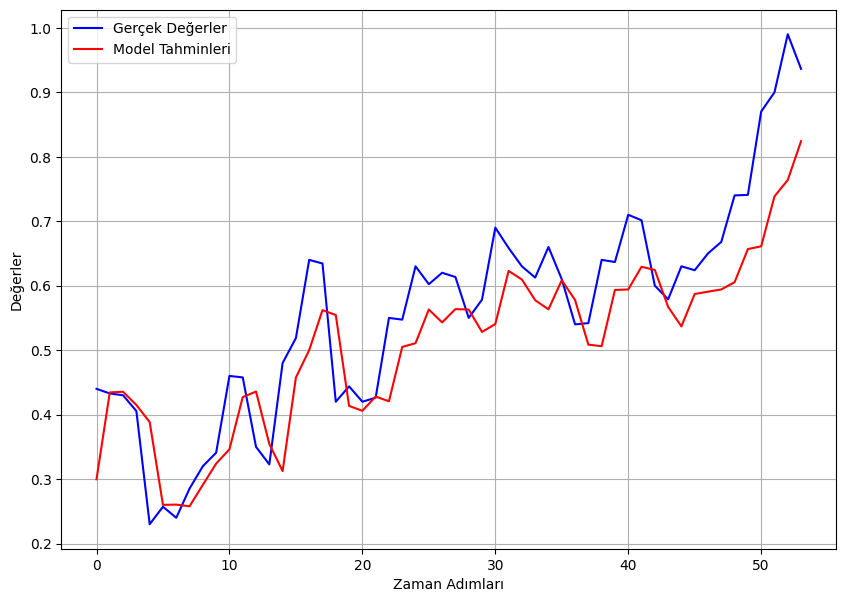

In [184]:
# Test verileri ve model tahminleri
y_true = tf.squeeze(test_labels)
y_pred = model_4_preds

# Timesteps dizisini test verilerinin uzunluğuna uygun olarak oluştur
timesteps = range(len(y_true))

# Gerçek değerleri çiz (mavi çizgi)
plt.figure(figsize=(10, 7))
plt.plot(timesteps, y_true, label="Gerçek Değerler", color="blue")

# Tahminleri çiz (kırmızı çizgi)
plt.plot(timesteps, y_pred, label="Model Tahminleri", color="red")

# Etiketler ve grafik düzenlemeleri
plt.xlabel("Zaman Adımları")
plt.ylabel("Değerler")
plt.legend()
plt.grid(True)

# Grafik göstermek için plt.show() kullanın
plt.show()

**Model 5: RNN (LSTM)**

In [195]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(64, activation="relu", return_sequences=True)(x)# using the tanh loss function results in a massive error
# Add another optional dense layer (you could add more of these to see if they improve model performance)
x = layers.LSTM(64, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
history_model_5=model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels))

Epoch 1/100
2/2 [==============================] - 5s 517ms/step - loss: 0.1801 - mae: 0.1801 - val_loss: 0.5664 - val_mae: 0.5664
Epoch 2/100
2/2 [==============================] - 0s 43ms/step - loss: 0.1766 - mae: 0.1766 - val_loss: 0.5759 - val_mae: 0.5759
Epoch 3/100
2/2 [==============================] - 0s 41ms/step - loss: 0.1731 - mae: 0.1731 - val_loss: 0.5846 - val_mae: 0.5846
Epoch 4/100
2/2 [==============================] - 0s 41ms/step - loss: 0.1701 - mae: 0.1701 - val_loss: 0.5934 - val_mae: 0.5934
Epoch 5/100
2/2 [==============================] - 0s 42ms/step - loss: 0.1675 - mae: 0.1675 - val_loss: 0.6024 - val_mae: 0.6024
Epoch 6/100
2/2 [==============================] - 0s 42ms/step - loss: 0.1649 - mae: 0.1649 - val_loss: 0.6114 - val_mae: 0.6114
Epoch 7/100
2/2 [==============================] - 0s 57ms/step - loss: 0.1624 - mae: 0.1624 - val_loss: 0.6203 - val_mae: 0.6203
Epoch 8/100
2/2 [==============================] - 0s 45ms/step - loss: 0.1603 - mae: 0.1

**# FARKLI BİR ŞEKİLDE KODLANMIŞ LSTM**

In [ ]:
tf.random.set_seed(42)

# Create model
model_90 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # reshape the inputs to be compatible with LSTM
  layers.LSTM(128, activation="relu", return_sequences=True),
  layers.LSTM(64, activation="relu", return_sequences=True),
  layers.LSTM(64, activation="relu"),
  layers.Dense(HORIZON)
], name="model_90_Deneme_lstm")

# Compile model
model_90.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
history_model_90 = model_90.fit(train_windows,
                             train_labels,
                             batch_size=128,
                             epochs=10,
                             verbose=1,
                             validation_data=(test_windows, test_labels),
                             callbacks=[create_model_checkpoint(model_name=model_90.name)])


In [196]:
# Load in best version of model 5 and evaluate on the test data
model_5.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 13ms/step - loss: 0.1218 - mae: 0.1218


[0.12177561223506927, 0.12177561223506927]

In [197]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

2/2 [==============================] - 0s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.2958933 , 0.42050108, 0.44288528, 0.42457378, 0.4073705 ,
       0.25776452, 0.24960373, 0.25498158, 0.27955285, 0.31340298],
      dtype=float32)>

In [198]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 0.12177561,
 'mse': 0.027934067,
 'rmse': 0.16713488,
 'mape': 20.86633,
 'mase': 2.3933356}

In [189]:
model_4_results

{'mae': 0.07068722,
 'mse': 0.008233899,
 'rmse': 0.09074084,
 'mape': 12.708786,
 'mase': 1.389262}

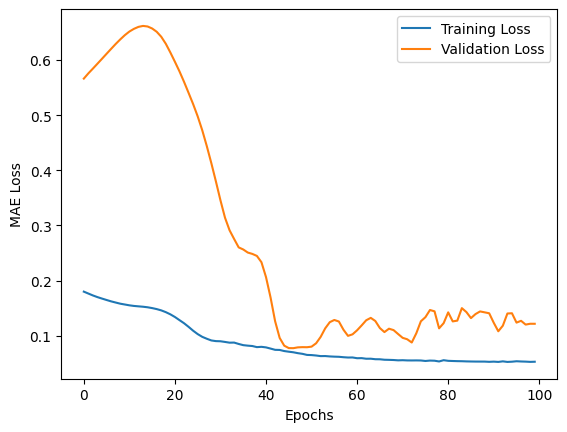

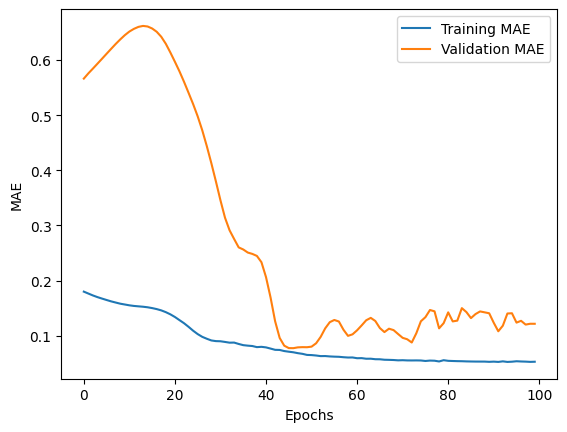

In [199]:
# Eğitimdeki kayıp değerlerini çizin
plt.plot(history_model_5.history['loss'], label='Training Loss')
plt.plot(history_model_5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

# Eğitimdeki metrik değerlerini çizin
plt.plot(history_model_5.history['mae'], label='Training MAE')
plt.plot(history_model_5.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

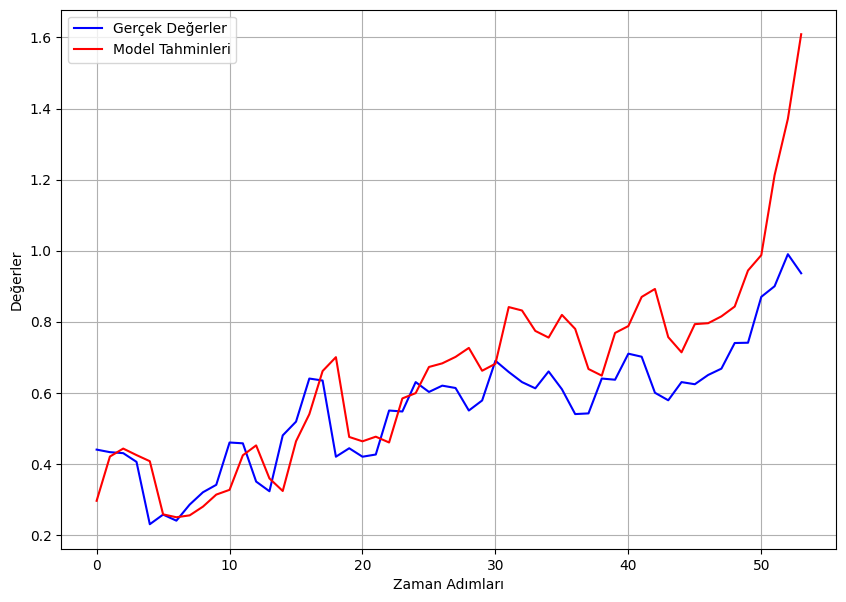

In [200]:
# Test verileri ve model tahminleri
y_true = tf.squeeze(test_labels)
y_pred = model_5_preds

# Timesteps dizisini test verilerinin uzunluğuna uygun olarak oluştur
timesteps = range(len(y_true))

# Gerçek değerleri çiz (mavi çizgi)
plt.figure(figsize=(10, 7))
plt.plot(timesteps, y_true, label="Gerçek Değerler", color="blue")

# Tahminleri çiz (kırmızı çizgi)
plt.plot(timesteps, y_pred, label="Model Tahminleri", color="red")

# Etiketler ve grafik düzenlemeleri
plt.xlabel("Zaman Adımları")
plt.ylabel("Değerler")
plt.legend()
plt.grid(True)

# Grafik göstermek için plt.show() kullanın
plt.show()

In [110]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [201]:
y_all = annual_df.dropna()["Mean"].to_numpy()

In [222]:
# How many timesteps to predict into the future?
INTO_FUTURE = 6 # since our Bitcoin data is daily, this is for 14 days

In [ ]:
y_all

In [223]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_4,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 148ms/step
Predicting on: 
 [0.6679 0.74   0.7408 0.87   0.8998 0.99   0.9363] -> Prediction: 0.8006763458251953

1/1 [==============================] - 0s 123ms/step
Predicting on: 
 [0.74       0.7408     0.87       0.8998     0.99       0.9363
 0.80067635] -> Prediction: 0.7274638414382935

1/1 [==============================] - 0s 52ms/step
Predicting on: 
 [0.7408     0.87       0.8998     0.99       0.9363     0.80067635
 0.72746384] -> Prediction: 0.6629794836044312

1/1 [==============================] - 0s 38ms/step
Predicting on: 
 [0.87       0.8998     0.99       0.9363     0.80067635 0.72746384
 0.66297948] -> Prediction: 0.6266006827354431

1/1 [==============================] - 0s 46ms/step
Predicting on: 
 [0.8998     0.99       0.9363     0.80067635 0.72746384 0.66297948
 0.62660068] -> Prediction: 0.5863561630249023

1/1 [==============================] - 0s 56ms/step
Predicting on: 
 [0.99       0.9363     0.80067635 0.727463

In [207]:
future_forecast[0]

0.80067635

In [226]:
future_forecast

[0.80067635, 0.72746384, 0.6629795, 0.6266007, 0.58635616, 0.5349303]

**Make a multivariate time series**

**ARIMA MODEL KURULUMU**

In [208]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF (t-istatistic)  : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("------------------------------------------------")
     print("P VALUE İÇİN :")
     if dftest[1]>0.05:
        print("Data DURAGAN DEGİL!")
     if dftest[1]<0.05:
        print("Data DURAGANDIR!")
     print("")
     print("ADF (T-ISTATISTIC) İÇİN :")
     counter=0
     for key, val in dftest[4].items():
      if (abs(dftest[0])<abs(val)):
        counter=counter+1
     if counter==len(dftest[4].items()):
      print("Data DURAGAN DEGİL!")
     else:
      print("Data DURAGANDIR")

     print("------------------------------------------------")
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

In [209]:
ad_test(annual_df_years['Mean'])

1. ADF (t-istatistic)  :  0.7936982058864102
2. P-Value :  0.9915337612629652
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression: 264
------------------------------------------------
P VALUE İÇİN :
Data DURAGAN DEGİL!

ADF (T-ISTATISTIC) İÇİN :
Data DURAGAN DEGİL!
------------------------------------------------
5. Critical Values :
	 1% :  -3.455365238788105
	 5% :  -2.8725510317187024
	 10% :  -2.5726375763314966


In [ ]:
!pip install pmdarima

In [212]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(annual_df_years['Mean'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-596.026, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-600.588, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-601.314, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-597.300, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-614.656, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-612.658, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-612.658, Time=1.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-601.519, Time=0.66 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-598.798, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-612.319, Time=0.40 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.756 seconds


In [213]:
len(annual_df_years['Mean'])

274

In [215]:
print(annual_df_years.shape)
train=annual_df_years.iloc[:-55]
test=annual_df_years.iloc[-55:]
print(train.shape,test.shape)

(274, 1)
(219, 1) (55, 1)


In [216]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA modelini oluşturun
model = ARIMA(train['Mean'], order=(1, 1, 1))

# Modeli uyarayın
model = model.fit()

# Model özetini görüntüleyin
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Mean   No. Observations:                  219
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 243.644
Date:                Wed, 13 Sep 2023   AIC                           -481.287
Time:                        20:48:01   BIC                           -471.134
Sample:                             0   HQIC                          -477.186
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6584      0.115      5.726      0.000       0.433       0.884
ma.L1         -0.8888      0.065    -13.685      0.000      -1.016      -0.762
sigma2         0.0063      0.001     11.073      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Year'>

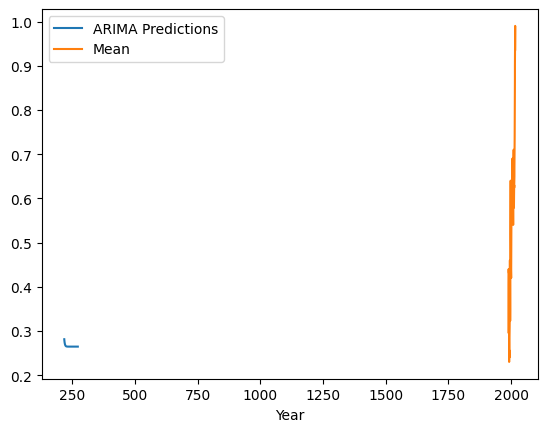

In [217]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Mean'].plot(legend=True)

In [218]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [219]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
test['Mean'].mean()
rmse=sqrt(mean_squared_error(pred,test['Mean']))
mae = mean_absolute_error(test['Mean'], pred)
mape = mean_absolute_percentage_error(test['Mean'], pred)

print("MAE:", mae)
print("RMSE",rmse)
print("MAPE:", mape)

MAE: 0.29165641114064345
RMSE 0.335728760837725
MAPE: 0.4748731109908478


In [ ]:
forecast = model.forecast(steps=14)

# Tahmin sonuçlarını görüntüle
print("İleriki 7 Veri Tahminleri:")
print(forecast)

**ARIMA MODEL SONU**

In [116]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

**Model 9: Train a model on the full historical data to make predictions into future**

In [ ]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [ ]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=1) # don't print out anything, we've seen this all before

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 606 # since our Bitcoin data is daily, this is for 14 days

In [109]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [ ]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

In [ ]:
future_forecast[:10]

[55980.406,
 50584.21,
 49496.65,
 49334.164,
 46336.785,
 46052.336,
 46874.516,
 54794.61,
 49513.64,
 49115.492]

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

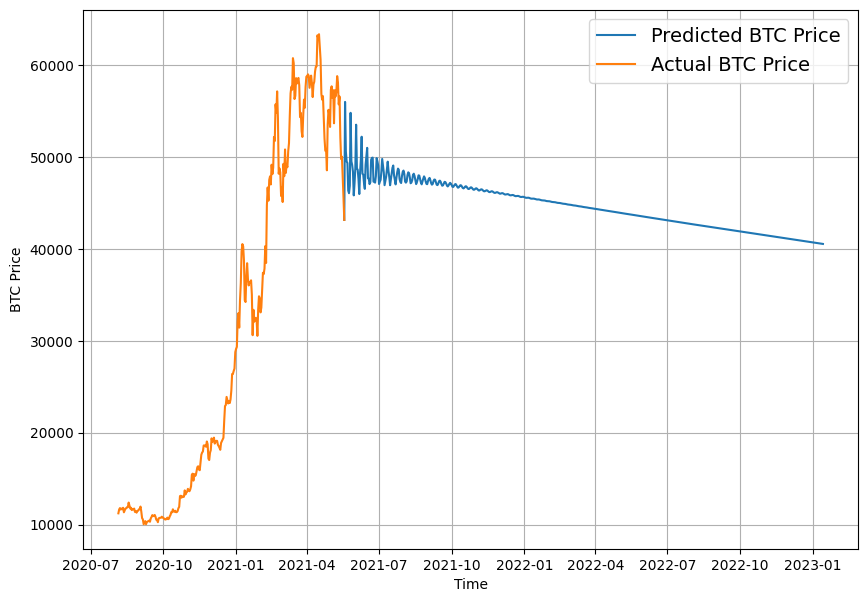

In [ ]:
# Plot future price predictions of Bitcoin
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")

**Model 10-Turkey Problem**

In [ ]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

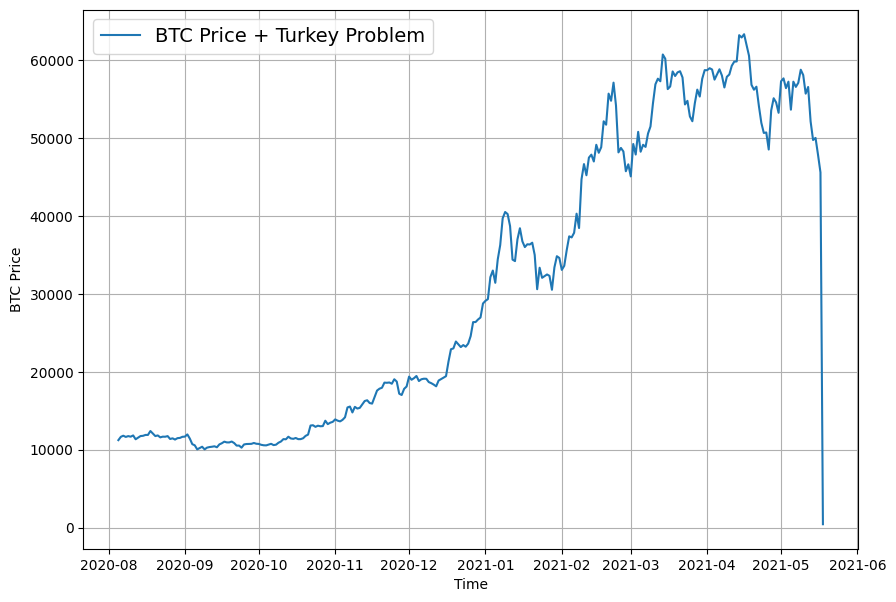

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [ ]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 650.7376


650.7376098632812

In [ ]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 640.4848


640.4848022460938

In [ ]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8812.694, 8762.549, 9027.351, 8741.661, 8728.252, 8720.906,
       8653.601, 8515.323, 8431.173, 8518.544], dtype=float32)>

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17130.586,
 'mse': 614501250.0,
 'rmse': 23715.8,
 'mape': 121.36588,
 'mase': 26.50964}

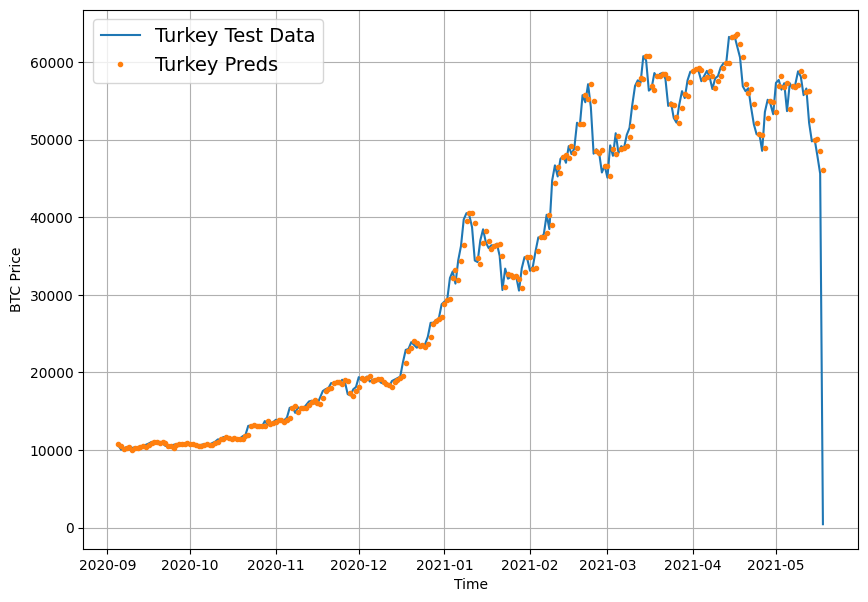

In [ ]:

plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");